In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import ipywidgets as widgets
from IPython.display import display, clear_output

# Introduction to NumPyro, Bayesian Inference, and Probabilistic Modeling

Much of the work we just did with understanding convolutions and Fourier Transforms was using a synthetic or cropped $h(t)$. But we know that we need to find a way to actually represent $h(t)$ without faking it; we want the real thing. Since $h(t)$ is unknown, we can use probabilistic inference (Bayesian inference via MCMC) to learn $h(t)$.

## What is Bayesian Inference?
Bayesian inference is about updating your beliefs about unknown things (parameters) using observed data.

We write this prior distribution as $p(x)$, aka the prior.

### 1. Start with a prior belief about a parameter
This is your initial assumption or uncertainty before seeing data. For example, you could say that "I believe the heartbeat shape $h(t)$ is probably smooth and close to zero."

### 2. You define a likelihood (how likely is the data given the parameter)?
This captures how you expect the data to behave, given a parameter.

We write this likelihood as $p(y | x)$, i.e. how well a given $h$ explains the observed $y$.

### 3. Apply Bayes' Rule to get the posterior
The whole point of Bayesian Inference is to get:
$$
p(x | y) = \frac{p(y | x) ⋅ p(x)}{p(y)}
$$
- $p(x ∣ y)$: posterior – your updated belief about $x$ after seeing data
- $p(y∣h)$: likelihood
- $p(x)$: prior


### How does this help us?
Bayesian Inference doesn't just give a point estimate, it gives us a:
- full distribution (in our case, a full distribution over all possible heartbeat shapes $h(t)$)
- Uncertainty about each feature (so we know details of each feature of $h(t)$)
- The ability to incoprorate prior knowledge (for $h(t)$, this involves info about the cardiovascular system, physics about how blood moves through your arteries, etc)


## What is MCMC?
Often, the denominator ($p(y)$) is really hard to compute exactly because it's a high-dimensional integral. This is where a set of algorithms called MCMC comes into play.

MCMC is a set of algorithms that let you draw samples from the posterior $p(x∣y)$, without computing the denominator. 

### Intuitive understanding:
- You can't compute the full distribution exactly.
- But you can generate a bunch of samples from it.
- Those samples tell you everything you need to know: mean, variance, etc.

### Detailed understanding:
- A Markov chain is a sequence of states (param values here) where each one depends only the previous one. MCMC uses this to explore param value possibilites but starting somewhere in the param space and "walking around," accepting or discarding new param values based on likeliness. Eventually, we settle on values.
- MCMC builds a Markov chain where each new sample depends only on the previous one.
- Over time, this chain converges to the desired probability distribution (e.g. our Bayesian posterior).
- By drawing many samples, we can approximate expectations, marginals, or make probabilistic predictions.

### How does this help us?
MCMC let's us:
- Treat parameters as random variables (e.g. the shape of h(t))
- Use observed data $y(t)$ to update your beliefs (compute the posterior)
- Get uncertainty estimates and distributions over $h(t)$, not just point estimates

Okay, so now we have to find a way to do all of this in code. We'll use NumPyro to do it.

## What is NumPyro?
NumPyro is a probabilistic programming library built on top of:
- JAX (for high-speed numerical computing and automatic differentiation)
- NumPy

It’s designed to let you define probabilistic models and perform Bayesian inference.

### How does this help us:
In NumPyro, you define:
- A prior over parameters (e.g. σ, etc.)
- A likelihood (how you model the data)
- Then use MCMC to draw samples from the posterior

## Try it out:

It's helpful to see all of these components in play with each other, so let's look at an example.

Read the code to understand what each part is doing.

### Run #1
- set the true amp to 10
- set the true width to 4
- set the prior amp to 1
- set the prior width to 0.3

What do you notice about the posterior? Why would this be the case?

### Run #2
- set the tru amp to 2
- set the true width 0.5
- set the prior amp to 4
- set hte prior width to 1

What do you notice about the posterior? Why would this be the case?

### Run #3
- set the tru amp to 2
- set the true width 0.5
- set the prior amp to 3
- set hte prior width to 0.7

What do you notice about the posterior? Why would this be the case?

sample: 100%|██████████| 1500/1500 [00:03<00:00, 460.00it/s, 15 steps of size 3.22e-01. acc. prob=0.92]


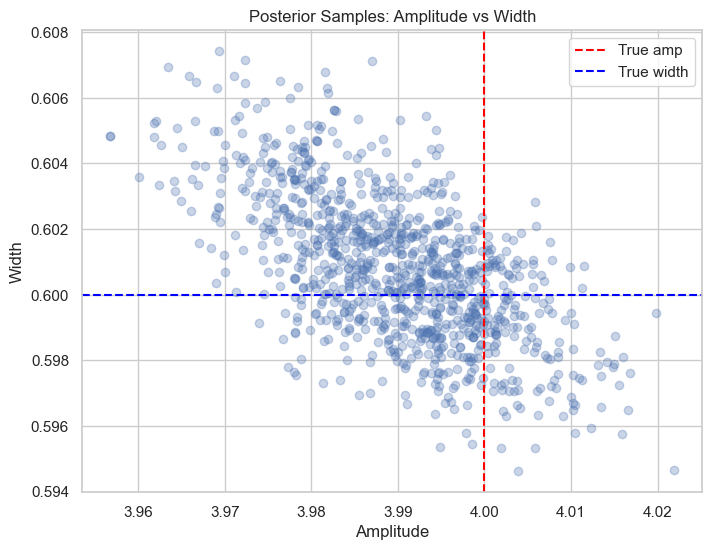

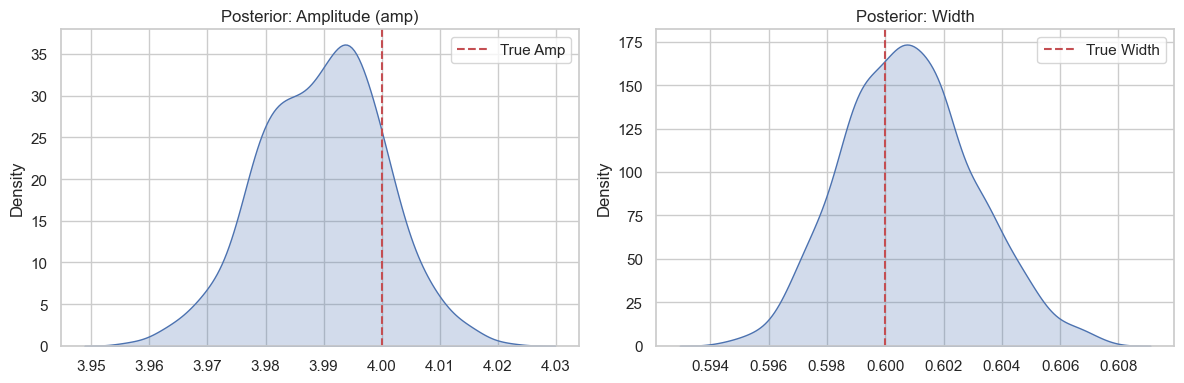

In [57]:
sns.set(style="whitegrid")

# Shared Gaussian kernel function
def gaussian_kernel(t, amp, width):
    return amp * np.exp(-0.5 * (t / width)**2)

# Interactive function
def run_mcmc(true_amp, true_width, amp_prior_scale, width_prior_scale):
    clear_output(wait=True)

    # Generate data
    t = np.linspace(-1, 1, 300)
    # t = np.random.normal(loc=true_amp, scale=true_width, size=200)  # larger, more varied dataset
    true_kernel = gaussian_kernel(t, true_amp, true_width)
    y_obs = true_kernel + np.random.normal(0, 0.1, size=len(t))

    # Define probabilistic model
    def model(t, y=None):
        # halfnormals used to avoid negative std deviation
        # The smaller the scale in HalfNormal(scale), the more confident you are that the parameter should be small
        amp = numpyro.sample("amp", dist.HalfNormal(amp_prior_scale))  # prior
        width = numpyro.sample("width", dist.HalfNormal(width_prior_scale))  # prior
        sigma = numpyro.sample("sigma", dist.HalfNormal(0.1))  # prior, standard deviation of obs noise
        kernel = amp * jnp.exp(-0.5 * (t / width)**2)
        with numpyro.plate("data", len(t)):
            # assume the y values are drawn from a normal distribution centered at kernel with standards deviation sigma
            # p(y | amp, width, sigma)
            numpyro.sample("obs", dist.Normal(kernel, sigma), obs=y)  # likelihood: how likely is the observed data given the parameters

    # Run MCMC
    # this is where we get posterior (by sampling from it)
    nuts_kernel = NUTS(model)  # "No U Turn Sampler" = NUTS
    mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, progress_bar=True)  # let model warm up
    mcmc.run(jax.random.PRNGKey(0), t=jnp.array(t), y=jnp.array(y_obs))
    samples = mcmc.get_samples()

    amp_samples = samples["amp"]
    width_samples = samples["width"]

    # Plot posterior samples
    plt.figure(figsize=(8, 6))
    plt.scatter(amp_samples, width_samples, alpha=0.3)
    plt.axvline(true_amp, color='red', linestyle='--', label='True amp')
    plt.axhline(true_width, color='blue', linestyle='--', label='True width')
    plt.xlabel("Amplitude")
    plt.ylabel("Width")
    plt.title("Posterior Samples: Amplitude vs Width")
    plt.legend()
    plt.show()


    # Plot marginal posterior distributions using samples
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.kdeplot(amp_samples, ax=axes[0], fill=True)
    axes[0].axvline(true_amp, color='r', linestyle='--', label='True Amp')
    axes[0].set_title("Posterior: Amplitude (amp)")
    axes[0].legend()

    sns.kdeplot(width_samples, ax=axes[1], fill=True)
    axes[1].axvline(true_width, color='r', linestyle='--', label='True Width')
    axes[1].set_title("Posterior: Width")
    axes[1].legend()

    plt.tight_layout()
    plt.show()



# Create interactive widgets
amp_slider = widgets.FloatSlider(description='True Amp', min=1, max=10.0, step=1, value=2.0)
width_slider = widgets.FloatSlider(description='True Width', min=0.1, max=5.0, step=0.1, value=0.3)
amp_prior_slider = widgets.FloatSlider(description='Amp Prior SD', min=1, max=20, step=1, value=2.0)
width_prior_slider = widgets.FloatSlider(description='Width Prior SD', min=0.1, max=20.0, step=0.1, value=0.3)
button = widgets.Button(description='Run MCMC')

# Hook up interaction
def on_button_click(b):
    run_mcmc(
        true_amp=amp_slider.value,
        true_width=width_slider.value,
        amp_prior_scale=amp_prior_slider.value,
        width_prior_scale=width_prior_slider.value,
    )

button.on_click(on_button_click)

# Display all widgets
display(widgets.VBox([amp_slider, width_slider, amp_prior_slider, width_prior_slider, button]))

We see that if are priors are:
   - weak but realistic, our posterior accuracy will good
   - strong but realistic, our posterior accuracy will be accurate (priors help here)
   - strong but wrong, and the data is phenomonal, our posterior will be inaccurate

A good prior doesn’t mean “narrow and correct,” it means “wide enough to allow the truth, but informed enough to help.”

Setting priors on $h$ is very important and can make or break your results. We don't want to be too loose, and we don't want to be too strict as well. Play around with the sliders until you have a strong intuition for the prior facts above. 

When you're doing MCMC using NumPyro, you will not be using a guassian kernel with two parameters (width and amp). You will have to try out differnet $h$'s to see which one best represents a heart beat, and use MCMC to model its parameters.